## Bring in first API dataset

In [ ]:
import requests
import pandas as pd
import json
import numpy as np
req=requests.get("https://api.covid19api.com/live/country/united-states").json()
covid=pd.DataFrame(req)

In [26]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6061 entries, 0 to 6060
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           6061 non-null   object
 1   Country      6061 non-null   object
 2   CountryCode  6061 non-null   object
 3   Province     6061 non-null   object
 4   City         6061 non-null   object
 5   CityCode     6061 non-null   object
 6   Lat          6061 non-null   object
 7   Lon          6061 non-null   object
 8   Confirmed    6061 non-null   int64 
 9   Deaths       6061 non-null   int64 
 10  Recovered    6061 non-null   int64 
 11  Active       6061 non-null   int64 
 12  Date         6061 non-null   object
dtypes: int64(4), object(9)
memory usage: 615.7+ KB


In [27]:
covid.describe()

,Confirmed,Deaths,Recovered,Active
count,6.061000e+03,6061.000000,6061.0,6.061000e+03
mean,6.882610e+05,11601.371391,0.0,6.766596e+05
std,8.389894e+05,14491.249485,0.0,8.249433e+05
min,0.000000e+00,0.000000,0.0,0.000000e+00
25%,1.400580e+05,2079.000000,0.0,1.378350e+05
50%,4.620780e+05,7284.000000,0.0,4.538920e+05
75%,8.416000e+05,13963.000000,0.0,8.293270e+05
max,4.791825e+06,70201.000000,0.0,4.721624e+06


* Look at the data tables in a graph. Use Seaborn library to create plot. 

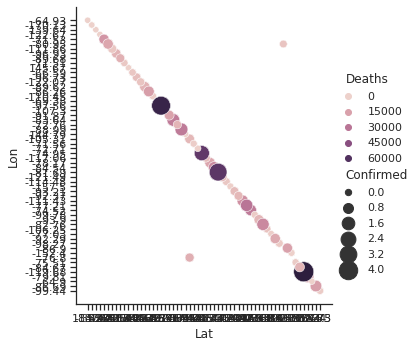

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.relplot(data=covid,x="Lat", y="Lon", hue="Deaths", size="Confirmed",
           sizes=(40, 400))

* The next few steps we will be converting the 'Lat' and 'Lon' data types from strings to floating numbers. 

In [29]:
covid['Lat'][0]

'18.35'

In [30]:
covid['Lat']= covid['Lat'].astype('float16')
covid['Lon']= covid['Lon'].astype('float16')

In [31]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6061 entries, 0 to 6060
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           6061 non-null   object 
 1   Country      6061 non-null   object 
 2   CountryCode  6061 non-null   object 
 3   Province     6061 non-null   object 
 4   City         6061 non-null   object 
 5   CityCode     6061 non-null   object 
 6   Lat          6061 non-null   float16
 7   Lon          6061 non-null   float16
 8   Confirmed    6061 non-null   int64  
 9   Deaths       6061 non-null   int64  
 10  Recovered    6061 non-null   int64  
 11  Active       6061 non-null   int64  
 12  Date         6061 non-null   object 
dtypes: float16(2), int64(4), object(7)
memory usage: 544.7+ KB


* Replot the graph using Seaborn and the new 'Lat' and 'Lon' floating numbers.

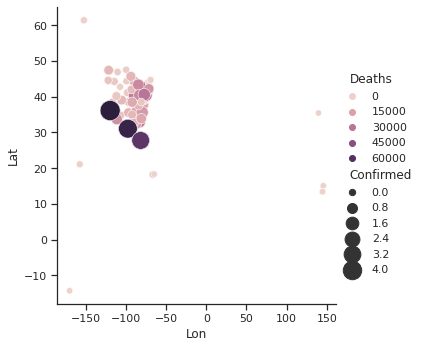

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.relplot(data=covid,x="Lon", y="Lat", hue="Deaths", size="Confirmed",
           sizes=(40, 400))

* Size of the graph is adjusted using set limits for the x and y axis. This allows us to distinguish the data points from the cluster of the graph above. 

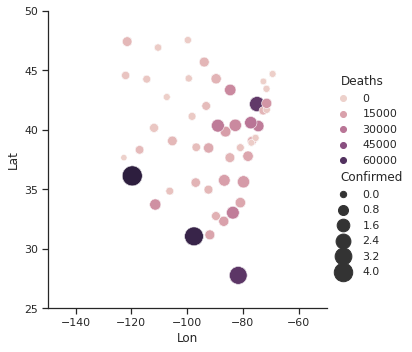

In [38]:
fig=sns.relplot(data=covid,x="Lon", y="Lat", hue="Deaths", size="Confirmed",
           sizes=(40, 400)).set(ylim=(25,50),xlim=(-150,-50))

* We want to correlate beds per 10,000 populations to mortality for COVID. Bring in the second data set that tells us about the number of beds per sample. We will need to organize this data by aggregating by county in order to get the total number of beds per county.

In [34]:
req=requests.get("https://www.communitybenefitinsight.org/api/get_hospitals.php").json()
hospitals=pd.DataFrame(req)
hospitals.head()

,hospital_id,hospital_org_id,ein,name,name2,name3,street_address,city,state,zip_code,...,fips_state_and_county_code,hospital_bed_count,chrch_affl_f,urban_location_f,children_hospital_f,memb_counc_teach_hosps_f,medicare_provider_number,county,hospital_bed_size,updated_dt
0,1,1,630307951,Mizell Memorial Hospital,,Mizell Memorial Hospital,702 Main Street,Opp,AL,36462,...,01039,99,N,N,N,N,010007,Covington County,<100 beds,"October 1, 2021"
1,2,2,630578923,St Vincents East,,St Vincents East,50 Medical Park Drive East,Birmingham,AL,35235,...,01073,362,N,Y,N,Y,010011,Jefferson County,>299 beds,"October 1, 2021"
2,3,3,630312913,Shelby Baptist Medical Center,,Shelby Baptist Medical Center,1000 First Street North,Alabaster,AL,35007,...,01117,252,N,Y,N,N,010016,Shelby County,100-299 beds,"October 1, 2021"
3,4,4,630459034,Callahan Eye Foundation Hosp,,Callahan Eye Foundation Hosp,1720 University Boulevard,Birmingham,AL,35233,...,01073,106,N,Y,N,Y,010018,Jefferson County,100-299 beds,"October 1, 2021"
4,5,5,581973570,Cherokee Medical Center,,Cherokee Medical Center,100 Northwood Drive,Centre,AL,35960,...,01019,60,N,N,N,N,010022,Cherokee County,<100 beds,"October 1, 2021"


### Create Hospital Info Per County Table
* Here I will need to turn the string in hospital_bedcount to a number. 

In [39]:
hospitals['state_county']=hospitals['state']+'_'+hospitals['county']
hospitals.head()

,hospital_id,hospital_org_id,ein,name,name2,name3,street_address,city,state,zip_code,...,hospital_bed_count,chrch_affl_f,urban_location_f,children_hospital_f,memb_counc_teach_hosps_f,medicare_provider_number,county,hospital_bed_size,updated_dt,state_county
0,1,1,630307951,Mizell Memorial Hospital,,Mizell Memorial Hospital,702 Main Street,Opp,AL,36462,...,99,N,N,N,N,010007,Covington County,<100 beds,"October 1, 2021",AL_Covington County
1,2,2,630578923,St Vincents East,,St Vincents East,50 Medical Park Drive East,Birmingham,AL,35235,...,362,N,Y,N,Y,010011,Jefferson County,>299 beds,"October 1, 2021",AL_Jefferson County
2,3,3,630312913,Shelby Baptist Medical Center,,Shelby Baptist Medical Center,1000 First Street North,Alabaster,AL,35007,...,252,N,Y,N,N,010016,Shelby County,100-299 beds,"October 1, 2021",AL_Shelby County
3,4,4,630459034,Callahan Eye Foundation Hosp,,Callahan Eye Foundation Hosp,1720 University Boulevard,Birmingham,AL,35233,...,106,N,Y,N,Y,010018,Jefferson County,100-299 beds,"October 1, 2021",AL_Jefferson County
4,5,5,581973570,Cherokee Medical Center,,Cherokee Medical Center,100 Northwood Drive,Centre,AL,35960,...,60,N,N,N,N,010022,Cherokee County,<100 beds,"October 1, 2021",AL_Cherokee County


In [40]:
HospitalInfoPerCounty=hospitals.groupby(['state_county'], as_index=False)['hospital_bed_count'].agg('sum')
HospitalInfoPerCounty.head()

,state_county,hospital_bed_count
0,AK_Anchorage Municipality,401
1,AK_Fairbanks North Star Borough,162
2,AK_Kenai Peninsula Borough,49622
3,AK_Ketchikan Gateway Borough,25
4,AK_Kodiak Island Borough,25


In [42]:
hospitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3380 entries, 0 to 3379
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   hospital_id                 3380 non-null   object
 1   hospital_org_id             3380 non-null   object
 2   ein                         3380 non-null   object
 3   name                        3380 non-null   object
 4   name2                       3380 non-null   object
 5   name3                       3380 non-null   object
 6   street_address              3380 non-null   object
 7   city                        3380 non-null   object
 8   state                       3380 non-null   object
 9   zip_code                    3380 non-null   object
 10  american_association_id     3380 non-null   object
 11  fips_state_and_county_code  3380 non-null   object
 12  hospital_bed_count          3380 non-null   object
 13  chrch_affl_f                3380 non-null   obje

In [43]:
hospitals['hospital_bed_count'][0]

'99'

In [44]:
hospitals['hospital_bed_count'] = hospitals['hospital_bed_count'].astype('float16')

In [45]:
hospitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3380 entries, 0 to 3379
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hospital_id                 3380 non-null   object 
 1   hospital_org_id             3380 non-null   object 
 2   ein                         3380 non-null   object 
 3   name                        3380 non-null   object 
 4   name2                       3380 non-null   object 
 5   name3                       3380 non-null   object 
 6   street_address              3380 non-null   object 
 7   city                        3380 non-null   object 
 8   state                       3380 non-null   object 
 9   zip_code                    3380 non-null   object 
 10  american_association_id     3380 non-null   object 
 11  fips_state_and_county_code  3380 non-null   object 
 12  hospital_bed_count          3380 non-null   float16
 13  chrch_affl_f                3380 

### Create a Hospital Info Per County and Sum for hospital_bed_count
* We will also need to approximate to structure the data in the API. We only keep matches that end in ```County```. This will give us the majority of data. 

In [51]:
HospitalInfoPerCounty=hospitals.groupby(['state_county'], as_index=False)['hospital_bed_count'].agg('sum')
HospitalInfoPerCounty.head()

,state_county,hospital_bed_count
0,AK_Anchorage Municipality,401.0
1,AK_Fairbanks North Star Borough,162.0
2,AK_Kenai Peninsula Borough,77.0
3,AK_Ketchikan Gateway Borough,25.0
4,AK_Kodiak Island Borough,25.0


In [52]:
HospitalInfoPerCounty['state_county']=HospitalInfoPerCounty['state_county'].str.replace(' County','')
HospitalInfoPerCounty.head(5)

,state_county,hospital_bed_count
0,AK_Anchorage Municipality,401.0
1,AK_Fairbanks North Star Borough,162.0
2,AK_Kenai Peninsula Borough,77.0
3,AK_Ketchikan Gateway Borough,25.0
4,AK_Kodiak Island Borough,25.0


### Create Covid Per County DataFrame
* Call ```covid``` data set from first API and curate it for use to compare with the ```hospital``` data set.
* We will see that the states are written out as the full name and not the two letter code in the ```covid``` dataset. 
    * We will need to change the full name to the two letter code using a state dictionary. 
* We will then need to create a key to join the tables by concatenating and creating an inner. 

In [55]:
import requests
import pandas as pd
import json
import numpy as np
req=requests.get("https://webhooks.mongodb-stitch.com/api/client/v2.0/app/covid-19-qppza/service/REST-API/incoming_webhook/us_only?min_date=2021-01-15T00:00:00.000Z&max_date=2021-01-15T00:00:00.000Z").json()
covid=pd.DataFrame(req)
covid.head()

,_id,uid,country_iso2,country_iso3,country_code,fips,county,state,country,combined_name,population,loc,date,confirmed,deaths,confirmed_daily,deaths_daily
0,6166376082b1870026b9adfc,84001001,US,USA,840,1001.0,Autauga,Alabama,US,"Autauga, Alabama, US",55869.0,"{'type': 'Point', 'coordinates': [-86.6441, 32...",2021-01-15T00:00:00.000Z,5103,55,28,0
1,6166376082b1870026b9b071,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,"Baldwin, Alabama, US",223234.0,"{'type': 'Point', 'coordinates': [-87.7221, 30...",2021-01-15T00:00:00.000Z,16002,179,161,2
2,6166376082b1870026b9b2e6,84001005,US,USA,840,1005.0,Barbour,Alabama,US,"Barbour, Alabama, US",24686.0,"{'type': 'Point', 'coordinates': [-85.3871, 31...",2021-01-15T00:00:00.000Z,1712,36,16,0
3,6166376082b1870026b9b55b,84001007,US,USA,840,1007.0,Bibb,Alabama,US,"Bibb, Alabama, US",22394.0,"{'type': 'Point', 'coordinates': [-87.1251, 32...",2021-01-15T00:00:00.000Z,2130,47,17,0
4,6166376082b1870026b9b7d0,84001009,US,USA,840,1009.0,Blount,Alabama,US,"Blount, Alabama, US",57826.0,"{'type': 'Point', 'coordinates': [-86.5679, 33...",2021-01-15T00:00:00.000Z,5264,83,45,3


Converting states to a two letter code using a dictionary

In [56]:
us_state_to_abbrev = {
"Alabama": "AL","Alaska": "AK","Arizona": "AZ","Arkansas": "AR", "California": "CA",
"Colorado": "CO","Connecticut": "CT","Delaware": "DE","Florida": "FL","Georgia": "GA",
"Hawaii": "HI","Idaho": "ID","Illinois": "IL","Indiana": "IN","Iowa": "IA","Kansas": "KS",
"Kentucky": "KY","Louisiana": "LA","Maine": "ME","Maryland": "MD","Massachusetts": "MA",
"Michigan": "MI","Minnesota": "MN","Mississippi": "MS","Missouri": "MO","Montana": "MT",
"Nebraska": "NE","Nevada": "NV","New Hampshire": "NH","New Jersey": "NJ","New Mexico": "NM",
"New York": "NY","North Carolina": "NC","North Dakota": "ND","Ohio": "OH",
"Oklahoma": "OK","Oregon": "OR","Pennsylvania": "PA","Rhode Island": "RI",
"South Carolina": "SC","South Dakota": "SD","Tennessee": "TN","Texas": "TX",
"Utah": "UT","Vermont": "VT","Virginia": "VA","Washington": "WA",
"West Virginia": "WV","Wisconsin": "WI","Wyoming": "WY",
"District of Columbia": "DC","American Samoa": "AS","Guam": "GU", "Northern Mariana Islands": "MP",
"Puerto Rico": "PR","United States Minor Outlying Islands": "UM","U.S. Virgin Islands": "VI",
}
covid['state'].replace(us_state_to_abbrev, inplace=True)
covid.head(5)

,_id,uid,country_iso2,country_iso3,country_code,fips,county,state,country,combined_name,population,loc,date,confirmed,deaths,confirmed_daily,deaths_daily
0,6166376082b1870026b9adfc,84001001,US,USA,840,1001.0,Autauga,AL,US,"Autauga, Alabama, US",55869.0,"{'type': 'Point', 'coordinates': [-86.6441, 32...",2021-01-15T00:00:00.000Z,5103,55,28,0
1,6166376082b1870026b9b071,84001003,US,USA,840,1003.0,Baldwin,AL,US,"Baldwin, Alabama, US",223234.0,"{'type': 'Point', 'coordinates': [-87.7221, 30...",2021-01-15T00:00:00.000Z,16002,179,161,2
2,6166376082b1870026b9b2e6,84001005,US,USA,840,1005.0,Barbour,AL,US,"Barbour, Alabama, US",24686.0,"{'type': 'Point', 'coordinates': [-85.3871, 31...",2021-01-15T00:00:00.000Z,1712,36,16,0
3,6166376082b1870026b9b55b,84001007,US,USA,840,1007.0,Bibb,AL,US,"Bibb, Alabama, US",22394.0,"{'type': 'Point', 'coordinates': [-87.1251, 32...",2021-01-15T00:00:00.000Z,2130,47,17,0
4,6166376082b1870026b9b7d0,84001009,US,USA,840,1009.0,Blount,AL,US,"Blount, Alabama, US",57826.0,"{'type': 'Point', 'coordinates': [-86.5679, 33...",2021-01-15T00:00:00.000Z,5264,83,45,3


In [57]:
covid['state_county']=covid['state']+'_'+covid['county']
covid.head()

,_id,uid,country_iso2,country_iso3,country_code,fips,county,state,country,combined_name,population,loc,date,confirmed,deaths,confirmed_daily,deaths_daily,state_county
0,6166376082b1870026b9adfc,84001001,US,USA,840,1001.0,Autauga,AL,US,"Autauga, Alabama, US",55869.0,"{'type': 'Point', 'coordinates': [-86.6441, 32...",2021-01-15T00:00:00.000Z,5103,55,28,0,AL_Autauga
1,6166376082b1870026b9b071,84001003,US,USA,840,1003.0,Baldwin,AL,US,"Baldwin, Alabama, US",223234.0,"{'type': 'Point', 'coordinates': [-87.7221, 30...",2021-01-15T00:00:00.000Z,16002,179,161,2,AL_Baldwin
2,6166376082b1870026b9b2e6,84001005,US,USA,840,1005.0,Barbour,AL,US,"Barbour, Alabama, US",24686.0,"{'type': 'Point', 'coordinates': [-85.3871, 31...",2021-01-15T00:00:00.000Z,1712,36,16,0,AL_Barbour
3,6166376082b1870026b9b55b,84001007,US,USA,840,1007.0,Bibb,AL,US,"Bibb, Alabama, US",22394.0,"{'type': 'Point', 'coordinates': [-87.1251, 32...",2021-01-15T00:00:00.000Z,2130,47,17,0,AL_Bibb
4,6166376082b1870026b9b7d0,84001009,US,USA,840,1009.0,Blount,AL,US,"Blount, Alabama, US",57826.0,"{'type': 'Point', 'coordinates': [-86.5679, 33...",2021-01-15T00:00:00.000Z,5264,83,45,3,AL_Blount


In [58]:
CovidPerCounty=covid.groupby(['state_county'], as_index=False).agg({'deaths':'sum','confirmed':'sum','population':'sum','confirmed_daily':'mean','deaths_daily':'mean'})
CovidPerCounty.head(15)

,state_county,deaths,confirmed,population,confirmed_daily,deaths_daily
0,AK_Aleutians East,0,40,3337.0,1.0,0.0
1,AK_Aleutians West,0,242,5634.0,3.0,0.0
2,AK_Anchorage,129,24530,288000.0,92.0,0.0
3,AK_Bethel,12,2911,18386.0,26.0,0.0
4,AK_Bristol Bay,0,0,836.0,0.0,0.0
5,AK_Bristol Bay plus Lake and Peninsula,0,163,2428.0,1.0,0.0
6,AK_Chugach,3,241,6751.0,0.0,0.0
7,AK_Copper River,0,175,2699.0,1.0,0.0
8,AK_Denali,0,63,2097.0,0.0,0.0
9,AK_Dillingham,1,150,4916.0,1.0,0.0


In [59]:
CovidPerCounty['mortality']=CovidPerCounty['deaths']/CovidPerCounty['confirmed']
CovidPerCounty.head(5)

,state_county,deaths,confirmed,population,confirmed_daily,deaths_daily,mortality
0,AK_Aleutians East,0,40,3337.0,1.0,0.0,0.000000
1,AK_Aleutians West,0,242,5634.0,3.0,0.0,0.000000
2,AK_Anchorage,129,24530,288000.0,92.0,0.0,0.005259
3,AK_Bethel,12,2911,18386.0,26.0,0.0,0.004122
4,AK_Bristol Bay,0,0,836.0,0.0,0.0,NaN


In [60]:
Hospital_Covid_PerCounty=pd.merge(HospitalInfoPerCounty,CovidPerCounty,on='state_county')
Hospital_Covid_PerCounty=Hospital_Covid_PerCounty[Hospital_Covid_PerCounty['population']>50000]
Hospital_Covid_PerCounty=Hospital_Covid_PerCounty[Hospital_Covid_PerCounty['population']<300000]
Hospital_Covid_PerCounty=Hospital_Covid_PerCounty[Hospital_Covid_PerCounty['confirmed']>10]
Hospital_Covid_PerCounty.head()

,state_county,hospital_bed_count,deaths,confirmed,population,confirmed_daily,deaths_daily,mortality
0,AL_Baldwin,232.0,179,16002,223234.0,161.0,2.0,0.011186
1,AL_Blount,65.0,83,5264,57826.0,45.0,3.0,0.015767
2,AL_Calhoun,552.0,200,10982,113605.0,119.0,3.0,0.018212
8,AL_Cullman,115.0,104,7960,83768.0,38.0,10.0,0.013065
9,AL_Elmore,69.0,101,7723,81209.0,53.0,0.0,0.013078


In [80]:
Hospital_Covid_PerCounty['hospital_bed_count']

0       232.0
1        65.0
2       552.0
8       115.0
9        69.0
        ...  
1636    720.0
1641     70.0
1642    173.0
1649    343.0
1653    217.0
Name: hospital_bed_count, Length: 560, dtype: float16

In [81]:
people_per_bed=Hospital_Covid_PerCounty['population']/Hospital_Covid_PerCounty['hospital_bed_count']
print(people_per_bed)

0        962.215517
1        889.630769
2        205.806159
8        728.417391
9       1176.942029
           ...     
1636     146.683333
1641     806.428571
1642     424.052023
1649     243.492711
1653     368.009217
Length: 560, dtype: float64


In [84]:
both=Hospital_Covid_PerCounty
both

,state_county,hospital_bed_count,deaths,confirmed,population,confirmed_daily,deaths_daily,mortality
0,AL_Baldwin,232.0,179,16002,223234.0,161.0,2.0,0.011186
1,AL_Blount,65.0,83,5264,57826.0,45.0,3.0,0.015767
2,AL_Calhoun,552.0,200,10982,113605.0,119.0,3.0,0.018212
8,AL_Cullman,115.0,104,7960,83768.0,38.0,10.0,0.013065
9,AL_Elmore,69.0,101,7723,81209.0,53.0,0.0,0.013078
...,...,...,...,...,...,...,...,...
1636,WV_Monongalia,720.0,52,6311,105612.0,67.0,1.0,0.008240
1641,WV_Putnam,70.0,63,3444,56450.0,37.0,2.0,0.018293
1642,WV_Raleigh,173.0,37,3505,73361.0,79.0,1.0,0.010556
1649,WV_Wood,343.0,76,5993,83518.0,54.0,6.0,0.012681


In [85]:
both['people_per_bed']= people_per_bed
both

,state_county,hospital_bed_count,deaths,confirmed,population,confirmed_daily,deaths_daily,mortality,people_per_bed
0,AL_Baldwin,232.0,179,16002,223234.0,161.0,2.0,0.011186,962.215517
1,AL_Blount,65.0,83,5264,57826.0,45.0,3.0,0.015767,889.630769
2,AL_Calhoun,552.0,200,10982,113605.0,119.0,3.0,0.018212,205.806159
8,AL_Cullman,115.0,104,7960,83768.0,38.0,10.0,0.013065,728.417391
9,AL_Elmore,69.0,101,7723,81209.0,53.0,0.0,0.013078,1176.942029
...,...,...,...,...,...,...,...,...,...
1636,WV_Monongalia,720.0,52,6311,105612.0,67.0,1.0,0.008240,146.683333
1641,WV_Putnam,70.0,63,3444,56450.0,37.0,2.0,0.018293,806.428571
1642,WV_Raleigh,173.0,37,3505,73361.0,79.0,1.0,0.010556,424.052023
1649,WV_Wood,343.0,76,5993,83518.0,54.0,6.0,0.012681,243.492711


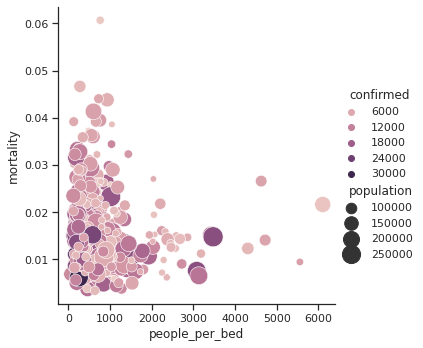

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.relplot(data=both,x="people_per_bed", y="mortality", hue="confirmed", size="population",
           sizes=(40,400))

* Final plot is above and it is seen that the amount of beds available is correlated to the mortality rate.